In [7]:
import nest_asyncio
from langgraph.graph import START, StateGraph, END
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
from typing import Literal
import os
import pickle
from openai import OpenAI
from dotenv import load_dotenv
from nodes import network_gathering_node, memory_summarizer_node, graph_and_exploitation_inference_node, exposure_manager_node, event_summarizer_node, firewall_node, save_iteration_node, node_utils
from configuration.state import HoneypotStateReact
from configuration import memory
from prompts import firewall_executor_prompt
nest_asyncio.apply()
import benchmark.benchmark as b


def display_graph(graph, width=300, height=300):

    png_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)

    display(Image(data=png_bytes, format="png", width=width, height=height)
)

def is_api_key_valid():
    try:
        client = OpenAI(api_key=node_utils.POLITO_CLUSTER_KEY, base_url=node_utils.POLITO_URL)
        response = client.chat.completions.create(
            model=node_utils.MISTRAL_STRING,
            messages=[{"role":"system", "content":"ciao"}],
            )
        print(response.choices[0].message.content)
    except Exception as e:
        print(f"Error: {e}")
        return False
    else:
        return True

In [8]:
# Load environment variables
load_dotenv()
os.environ["POLITO_CLUSTER_KEY"] = os.getenv("POLITO_CLUSTER_KEY")
#  Check the validity of the API key
api_key_valid = is_api_key_valid()
print("API key is valid:", api_key_valid)

INFO:httpx:HTTP Request: POST https://kubernetes.polito.it/vllm/v1/chat/completions "HTTP/1.1 200 OK"


 Ciao! How can I assist you today?
API key is valid: True


In [9]:
def should_continue_from_firewall(state: HoneypotStateReact) -> Literal["tools_firewall", "persistence_node"]:
    if hasattr(state, 'firewall_action'):
        return "tools_firewall"
    
    return "persistence_node"

In [10]:
def build_graph():
    graph = StateGraph(HoneypotStateReact)
    
    graph.add_node("network_gathering", network_gathering_node.network_gathering)
    graph.add_node("event_summarizer", event_summarizer_node.event_summarizer)
    graph.add_node("graph_and_exploitation_inference", graph_and_exploitation_inference_node.graph_and_exploitation_inference)
    graph.add_node("exposure_manager", exposure_manager_node.exposure_manager)
    graph.add_node("firewall_manager", firewall_node.firewall_executor)
    graph.add_node("persistence_node", save_iteration_node.save_iteration)
    graph.add_node("tools_firewall", firewall_node.tools_firewall)
 

    # Define execution order
    graph.add_edge(START, "network_gathering")
    graph.add_edge("network_gathering", "event_summarizer") 
    graph.add_edge("event_summarizer", "graph_and_exploitation_inference")
    graph.add_edge("graph_and_exploitation_inference", "exposure_manager")
    graph.add_edge("exposure_manager", "firewall_manager")
    graph.add_conditional_edges("firewall_manager", should_continue_from_firewall)
    graph.add_edge("tools_firewall", "persistence_node")
    graph.add_edge("persistence_node", END)

        
    return graph.compile()

def build_graph_test():
    graph = StateGraph(HoneypotStateReact)
    
    graph.add_node("network_gathering", network_gathering_node.network_gathering)
    graph.add_node("event_summarizer", event_summarizer_node.event_summarizer)
    

    # Define execution order
    graph.add_edge(START, "network_gathering")
    graph.add_edge("network_gathering", "event_summarizer") 
    graph.add_edge("event_summarizer", END)

        
    return graph.compile()

INFO:pyppeteer.launcher:Browser listening on: ws://127.0.0.1:58711/devtools/browser/24f560ab-95eb-4e19-8777-bd541e33c464
INFO:pyppeteer.launcher:terminate chrome process...


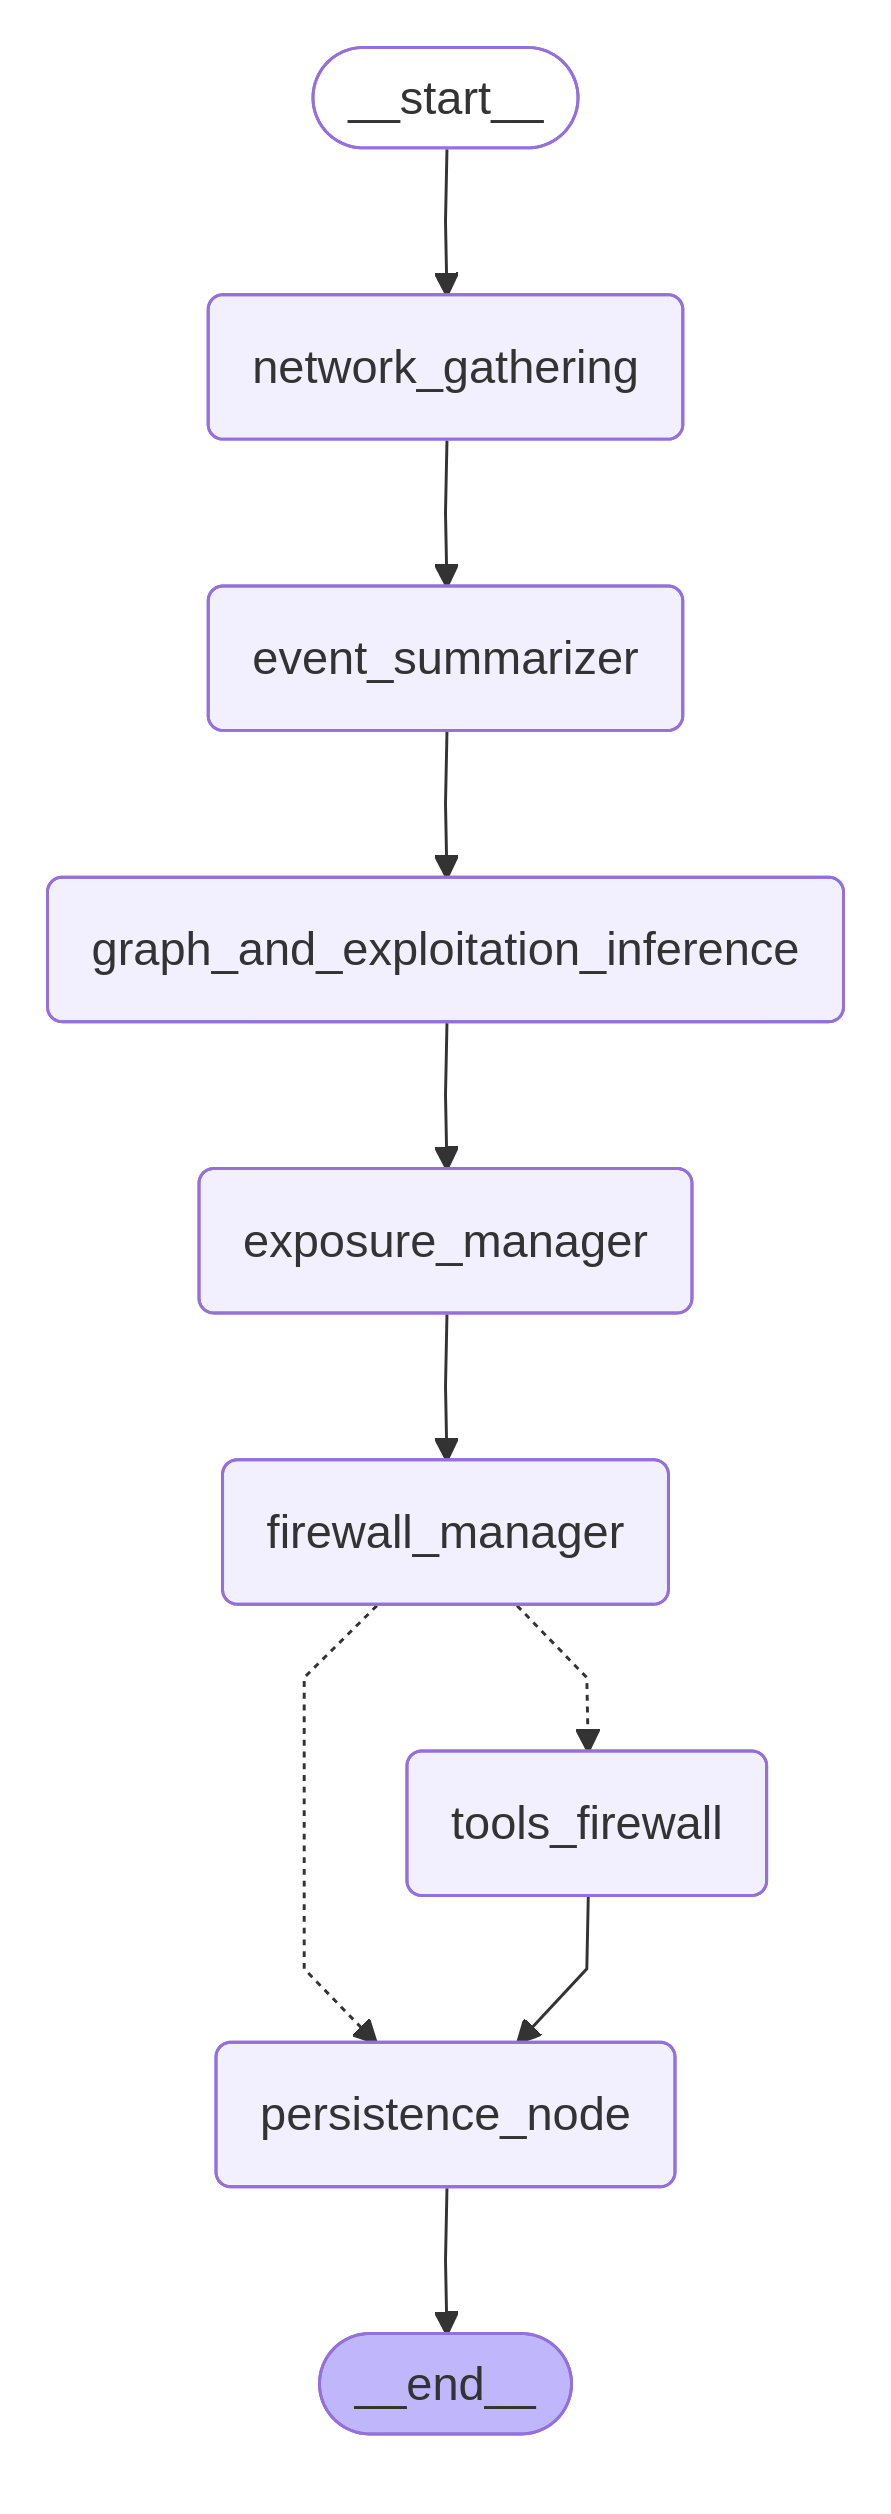

In [11]:
graph = build_graph()
# graph = build_graph_test()
display_graph(graph)

## Single Iteration

In [6]:
episodic_memory = memory.EpisodicMemory()

In [8]:
responses = []
for i in range(1):
    initial_state = HoneypotStateReact(
        messages=[]
    )
    response = await graph.ainvoke(initial_state, config={"configurable": {"store" : episodic_memory, "prompt":"eve", "time_window":2, "epoch_num":i+1, "model_config":"small:4.1"}})
    responses.append(response)

INFO:nodes.network_gathering_node:Network gathering Node
INFO:nodes.event_summarizer_node:Summarizer Agent
INFO:nodes.graph_and_exploitation_inference_node:Inference Agent
INFO:nodes.graph_and_exploitation_inference_node:Using: gpt-4.1
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes.exposure_manager_node:Exploitation Agent
INFO:nodes.exposure_manager_node:Exposure registry: {}
INFO:nodes.exposure_manager_node:Using: gpt-4.1
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes.firewall_node:Firewall Agent
INFO:nodes.firewall_node:Using: gpt-4.1-mini
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completi

In [9]:
for response in responses:
    for m in response['messages']:
        m.pretty_print()
with open(f"./responses.pkl", "wb") as f:
    pickle.dump(responses, f)

================================ Human Message =================================

{'alerts': [], 'time_window_minutes': 2, 'timestamp': '2025-09-23T15:58:03.751751Z', 'total_events': 0}
================================== Ai Message ==================================

No alerts retrieved
================================== Ai Message ==================================

Reasoning: No honeypots are available and no security events were found this epoch. As per guardrails, with no applicable evidence or services, the attack graph and exploitation status must remain unchanged.
Inferred Attack Graph: {'interesting': [], 'edges': []}
Honeypot Exploitation: []
================================== Ai Message ==================================

Reasoning: No honeypots are available to expose this epoch (the available honeypots list is empty). Per policy, if there are no honeypots eligible or available to expose, lockdown must be initiated.
Selected Honeypot: {}
Why not expose: [{'ip': 'all (none av

## Benchmark

In [12]:
episodic_memory = memory.EpisodicMemory()
dir_name = "test_3"

config_dict = {
            "max_epochs": 20,
            "attack_duration": 240,
            "monitor_accumulation_wait": 5,
            "firewall_update_wait": 2,
            "between_epoch_wait": 1,
            "stop_on_lockdown": True,
            "dir_name": dir_name
        }
runner = b.BenchmarkRunner(config_dict, episodic_memory=episodic_memory)
initial_state = HoneypotStateReact(
    messages=[]
)
responses = []
async def my_agent_executor(epoch_num: int):
    response = await graph.ainvoke(initial_state, config={
        "configurable": 
            {
            "store" : episodic_memory, 
            "time_window":2, 
            "prompt":"eve",
            "epoch_num": epoch_num,
            "model_config": "small:4.1"
            }
        }
    )
    responses.append(response)
    return response
    

results = runner.run(my_agent_executor)

INFO:benchmark.benchmark.Orchestrator:Starting benchmark run
INFO:benchmark.benchmark.AttackerController:Found existing attacker container: attacker
INFO:benchmark.benchmark.AttackerController:Successfully connected to attacker container
INFO:benchmark.benchmark.Orchestrator:
INFO:benchmark.benchmark.Orchestrator:EPOCH 1 STARTING
INFO:benchmark.benchmark.Orchestrator:============================================================

INFO:benchmark.benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.benchmark.Orchestrator:Starting attacker script with a fallback timeout of 240s...
INFO:benchmark.benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.benchmark.AttackerController:[ATTACK-1] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.benchmark.AttackerController:[ATTACK-1] ['/attacker/scripts/manager_exploit.py', '1']
INFO:benchmark.benchmark.AttackerController:[ATTACK-1] [

In [7]:
with open(f"./benchmark/benchmark_results/{dir_name}/responses.pkl", "wb") as f:
    pickle.dump(responses, f)
for i, response in enumerate(responses):
    
    print("=" * 130)
    print(f"Epoch: {i+1}")
    for m in response['messages']:
        m.pretty_print()
    print("-" * 130)

Epoch: 1
================================ Human Message =================================

{'alerts': [{'category': 'Attempted Information Leak', 'dest_ip': '172.20.0.9', 'dest_port': 443, 'flow_id': 675262877957569, 'payload': None, 'proto': 'TCP', 'severity': 2, 'signature': 'POSSBL PORT SCAN (NMAP -sS)', 'src_ip': '192.168.100.2', 'src_port': 62680, 'timestamp': '2025-09-24T17:04:26.419365+0200'}, {'category': 'Attempted Information Leak', 'dest_ip': '172.20.0.58', 'dest_port': 443, 'flow_id': 772065070812988, 'payload': None, 'proto': 'TCP', 'severity': 2, 'signature': 'POSSBL PORT SCAN (NMAP -sS)', 'src_ip': '192.168.100.2', 'src_port': 62678, 'timestamp': '2025-09-24T17:04:26.572976+0200'}, {'category': 'Attempted Information Leak', 'dest_ip': '172.20.0.89', 'dest_port': 443, 'flow_id': 782465797559282, 'payload': None, 'proto': 'TCP', 'severity': 2, 'signature': 'POSSBL PORT SCAN (NMAP -sS)', 'src_ip': '192.168.100.2', 'src_port': 62678, 'timestamp': '2025-09-24T17:04:26.575398+

In [8]:
dir_name = 'all_exploitable'
with open(f"./benchmark/benchmark_results/{dir_name}/responses.pkl", "rb") as f:
    saved_responses = pickle.load(f)

for i, res in enumerate(saved_responses):
    print(f"Epoch {i+1}")
    for m in res["messages"]:
        m.pretty_print()

Epoch 1
================================ Human Message =================================

{'alerts': [{'category': 'Misc activity', 'dest_ip': '192.168.100.254', 'dest_port': None, 'flow_id': 1147757474990773, 'payload': 'dl.h....1....................... !"#$%&\'()*+,-./01234567', 'proto': 'ICMP', 'severity': 3, 'signature': 'GPL ICMP PING *NIX', 'src_ip': '192.168.100.2', 'src_port': None, 'timestamp': '2025-09-15T21:43:32.529377+0200'}, {'category': 'Misc activity', 'dest_ip': '192.168.100.254', 'dest_port': None, 'flow_id': 1147757474990773, 'payload': 'el.h....]....................... !"#$%&\'()*+,-./01234567', 'proto': 'ICMP', 'severity': 3, 'signature': 'GPL ICMP PING *NIX', 'src_ip': '192.168.100.2', 'src_port': None, 'timestamp': '2025-09-15T21:43:33.578438+0200'}, {'category': 'Misc activity', 'dest_ip': '192.168.100.254', 'dest_port': None, 'flow_id': 1147757474990773, 'payload': 'fl.h...."-...................... !"#$%&\'()*+,-./01234567', 'proto': 'ICMP', 'severity': 3, 'sig